## **Training job skill extraction model**

Installing the required libraries

In [1]:
%pip install contractions
%pip install bert-for-tf2
%pip install tqdm
%pip install tensorflow_hub

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook 

# Upgrade from TF1 to TF2 for bert implementation
# tensorflow_version 2.8.0
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow import keras
from tensorflow.keras.layers import Input

# Params for bert model and tokenization
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

Matplotlib is building the font cache; this may take a moment.


In [3]:
print(tf.__version__)
print(hub.__version__)

2.7.0
0.12.0


In [4]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.gpu_device_name())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
/device:GPU:0


2022-04-07 07:51:25.239741: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:26.096592: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:26.097233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:26.150808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropri

In [5]:
colab_used = False
if colab_used:
    from google.colab import drive
    drive.mount('/content/drive')

###Data Import and Pre-processing

In [6]:
input_path_colab = "/content/drive/MyDrive/SFU/CMPT733/project/processing/"
input_path_lab = "processing/"

input_path = input_path_colab if colab_used else input_path_lab

input_file = "new_consolidated_records1_2022-03-26 173511_labelled.csv"

In [7]:
df1 = pd.read_csv(input_path+input_file, error_bad_lines = True)
#df2 = pd.read_csv(input_path+input_file_invalid, error_bad_lines = True)

#train_data = pd.concat([df1, df2], ignore_index=True)
train_data = df1

train_data.sample(100, random_state = 5)
train_data['text'] = train_data.text.str.strip()
train_data = train_data[train_data.text.str.strip()!='']

/tmp/ipykernel_36368/3750856104.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df1 = pd.read_csv(input_path+input_file, error_bad_lines = True)


In [8]:
train_data.sample(100, random_state = 5)

,Unnamed: 0,text,skill
2951,2903,financial advisor roles,1
5901,5807,progressive hr,1
6377,6280,retention policies,1
3833,3776,innate,0
1147,1125,change,0
...,...,...,...
4424,4363,market insight,1
4813,4747,multiple roles,0
4683,4620,modeling ability,1
5894,5800,programs,1


In [9]:
train_data['skill'].value_counts()

1    5800
0    2143
Name: skill, dtype: int64

In [10]:
# ratio of classes; checking for balance in training data 
print('Number of skill:', train_data['skill'].sum())
print('Number of Not Skill:', len(train_data['skill']) - train_data['skill'].sum())
print('Ratio of classes: Skill=', train_data['skill'].sum() / len(train_data['skill']), ' Not Skill=', 1 - train_data['skill'].sum() / len(train_data['skill']))

Number of skill: 5800
Number of Not Skill: 2143
Ratio of classes: Skill= 0.7302026941961476  Not Skill= 0.2697973058038524


### Model Training

In [21]:
# splitting data 1st iter 85/15 2nd iter 80/20 
# ensuring shuffling due to the sequentual nature of the training set
X = train_data["text"]
y = train_data["skill"]

X_train, X_test, y_train, y_test = train_test_split(
                                                    X, y, 
                                                    test_size = .2,
                                                    random_state = 42,
                                                    shuffle = True
                                                    )

print('{:>5,} training samples'.format(len(X_train)))
print('{:>5,} validation samples'.format(len(X_test)))

print(type(X_train))
print(type(X))

6,354 training samples
1,589 validation samples
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [12]:
# According to analysis the largest chunk captured by regex was 18 tokens long
max_seq_length = 18
# data should be np array with new dimension for input 
train_text = X_train[:, np.newaxis]
test_text = X_test[:, np.newaxis]
# always should check and check again
train_text.shape, test_text.shape

/tmp/ipykernel_36368/1553795918.py:4: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  train_text = X_train[:, np.newaxis]
/tmp/ipykernel_36368/1553795918.py:5: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  test_text = X_test[:, np.newaxis]


((6354, 1), (1589, 1))

### Tokenization

In [13]:
from keras.preprocessing.text import Tokenizer
num_words = 5000
max_length =18
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)

from keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(
    train_sequences, maxlen=max_length, padding="post", truncating="post"
)



### Embedding

In [14]:
"""Creates an embedding dictionary using GloVe"""
embedding_dict={}
with open('glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [15]:
"""Creates an embedding matrix, where each vector is the GloVe representation of a word in the corpus"""
embedding_matrix=np.zeros((num_words,100))
for word,i in tqdm_notebook (word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

/tmp/ipykernel_36368/1013508392.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for word,i in tqdm_notebook (word_index.items()):


  0%|          | 0/3514 [00:00<?, ?it/s]

### Model Built and Training

Performance not as good as the model with BERT Embedding...so will adopt the one with BERT instead

In [16]:
model_embed = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Embedding(num_words,100,embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                   input_length=max_length,trainable=False),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model_embed.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

2022-04-07 07:51:53.495567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:53.495745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:53.495854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:53.495993: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-07 07:51:53.496101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

In [32]:
history=model_embed.fit(train_padded,y_train,batch_size=4,epochs=20,validation_split=0.2,verbose=2)

Epoch 1/20
1271/1271 - 31s - loss: 0.4127 - accuracy: 0.8011 - val_loss: 0.3652 - val_accuracy: 0.8301 - 31s/epoch - 24ms/step
Epoch 2/20
1271/1271 - 32s - loss: 0.4091 - accuracy: 0.7991 - val_loss: 0.3637 - val_accuracy: 0.8316 - 32s/epoch - 25ms/step
Epoch 3/20
1271/1271 - 31s - loss: 0.4100 - accuracy: 0.7991 - val_loss: 0.3629 - val_accuracy: 0.8332 - 31s/epoch - 25ms/step
Epoch 4/20
1271/1271 - 32s - loss: 0.4015 - accuracy: 0.8070 - val_loss: 0.3587 - val_accuracy: 0.8356 - 32s/epoch - 25ms/step
Epoch 5/20
1271/1271 - 31s - loss: 0.4071 - accuracy: 0.7999 - val_loss: 0.3585 - val_accuracy: 0.8356 - 31s/epoch - 25ms/step
Epoch 6/20
1271/1271 - 32s - loss: 0.4062 - accuracy: 0.8001 - val_loss: 0.3561 - val_accuracy: 0.8340 - 32s/epoch - 25ms/step
Epoch 7/20
1271/1271 - 32s - loss: 0.4063 - accuracy: 0.8009 - val_loss: 0.3551 - val_accuracy: 0.8332 - 32s/epoch - 25ms/step
Epoch 8/20
1271/1271 - 32s - loss: 0.4008 - accuracy: 0.8072 - val_loss: 0.3534 - val_accuracy: 0.8324 - 32s/ep

In [18]:
model_embed.save(input_path+"job_skill_extraction_bert_lstm")

2022-04-07 08:00:01.946488: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: processing/job_skill_extraction_bert_lstm/assets


## **Model Evaluation**

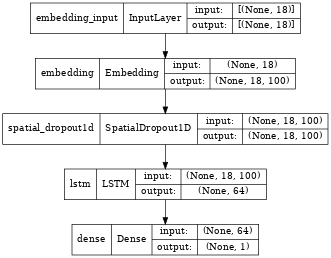

In [19]:
# After many interations to find an optimal structure this is the result
tf.keras.utils.plot_model(model_embed, show_shapes=True, dpi=48)


In [27]:
X_test.astype("string")

1163                                   channel management
2283                                     digital products
7155                               sustainable innovation
1421               competitive, demanding business sector
3296                                 great and personable
                              ...                        
3612                            human resource principles
339                                                alumni
121                                      active employees
5151    organization in-depth knowledge and industry r...
6779                                             sitstand
Name: text, Length: 1589, dtype: string

In [24]:
X_train

1090    capital planning and business requirements
3905                                      internal
1372                                       company
5976                           prospective clients
1317                                    colleagues
                           ...                    
5226                          other related fields
5390                                  packing work
860                                         branch
7603                       unit testing principles
7270                    technical and professional
Name: text, Length: 6354, dtype: object

In [39]:
# Accuracy on 1st iter ~85%; Accuracy on 2nd iter +0.5
tokenizer.fit_on_texts(X_test.astype("str"))
test_sequences = tokenizer.texts_to_sequences(X_test.astype("str"))

test_padded = pad_sequences(
    test_sequences, maxlen=max_length, padding="post", truncating="post"
)

accr = model_embed.evaluate(test_padded, y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

50/50 [==============================] - 0s 8ms/step - loss: 0.7303 - accuracy: 0.6545
Test set
  Loss: 0.730
  Accuracy: 0.654
